# *Predict the Introverts from the Extroverts*

![](https://www.kaggle.com/competitions/91718/images/header)

In [1]:
import pandas as pd
# pandas: veri işleme ve analiz kütüphanesi

from tensorflow.keras.models import Sequential
# Sequential: katmanları sırayla ekleyerek model kurmamızı sağlar

from tensorflow.keras.layers import Dense
# Dense: tam bağlantılı (fully connected) yapay sinir ağı katmanı

from sklearn.preprocessing import StandardScaler
# Verileri ölçeklemek (standartlaştırmak) için kullanılan sınıf

import warnings
warnings.filterwarnings('ignore')

# warnings kütüphanesi, çalışma sırasında çıkan uyarı mesajlarını kontrol eder.
# Bu satır uyarı mesajlarını gizleyerek çıktının temiz görünmesini sağlar.

import matplotlib.pyplot as plt
import seaborn as sns 

# matplotlib.pyplot ve seaborn kütüphaneleri veri görselleştirme için kullanılır.
# plt temel grafik çizimlerinde, sns ise daha gelişmiş ve estetik grafiklerde tercih edilir.

2026-02-10 18:33:35.458701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770748415.713492      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770748415.787994      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770748416.360016      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770748416.360066      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770748416.360069      55 computation_placer.cc:177] computation placer alr

## *Read Data*

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [3]:
df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')

# '/kaggle/input/playground-series-s5e7/train.csv' adlı CSV dosyasını okur ve veriyi bir pandas DataFrame'i olarak 'df' değişkenine yükler.

## *Exploratory Data Analysis*

In [4]:
df.head()
# Veri setinin ilk 5 satırını görüntüler.
# Bu, veri yapısını ve sütunları genel olarak incelemek için kullanılır.

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [5]:
df.sample()
# Veri setinden rastgele bir satır (veya satırlar) getirir.
# Veri kontrolü ve genel görünüm hakkında fikir edinmek için yararlıdır.

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
16404,16404,6.0,Yes,3.0,1.0,Yes,NaN,1.0,Introvert


In [6]:
df.isnull().sum()
# Her sütunda kaç adet eksik (NaN) değer bulunduğunu gösterir.
# Eksik veri analizi yapmak için kullanılır.

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

In [7]:
df.shape
# Veri setinin boyutlarını (satır, sütun) bir demet (tuple) olarak döndürür.
# Örneğin (1470, 35) gibi bir çıktı verir.

(18524, 9)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [9]:
df.columns
# DataFrame’deki sütun isimlerini listeler

Index(['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')

In [10]:
df["Personality"] = df["Personality"].map({
    "Introvert": 0,
    "Extrovert": 1
})

print(df["Personality"].dtype)
print(df["Personality"].unique())

int64
[1 0]


In [11]:
binary_map = {"Yes": 1, "No": 0}

df["Stage_fear"] = df["Stage_fear"].map(binary_map)
df["Drained_after_socializing"] = df["Drained_after_socializing"].map(binary_map)

## *Missing Data*

In [12]:
# Eksik oranını hesapla
missing_ratio = df.isnull().mean()

In [13]:
# %40'tan fazla eksik olan sütunları sil
df = df.loc[:, missing_ratio < 0.4]

In [14]:
# Sayısal ve kategorik ayır
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df.select_dtypes(include=["object", "bool"]).columns

In [15]:
# Sayısalları median, kategorikleri mode ile doldur
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))

In [16]:
df.isnull().sum()

id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

In [17]:
X = df.drop("Personality", axis=1)
y = df["Personality"]

## *Data Visualization¶*

In [18]:
# Sayısal sütunlar
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

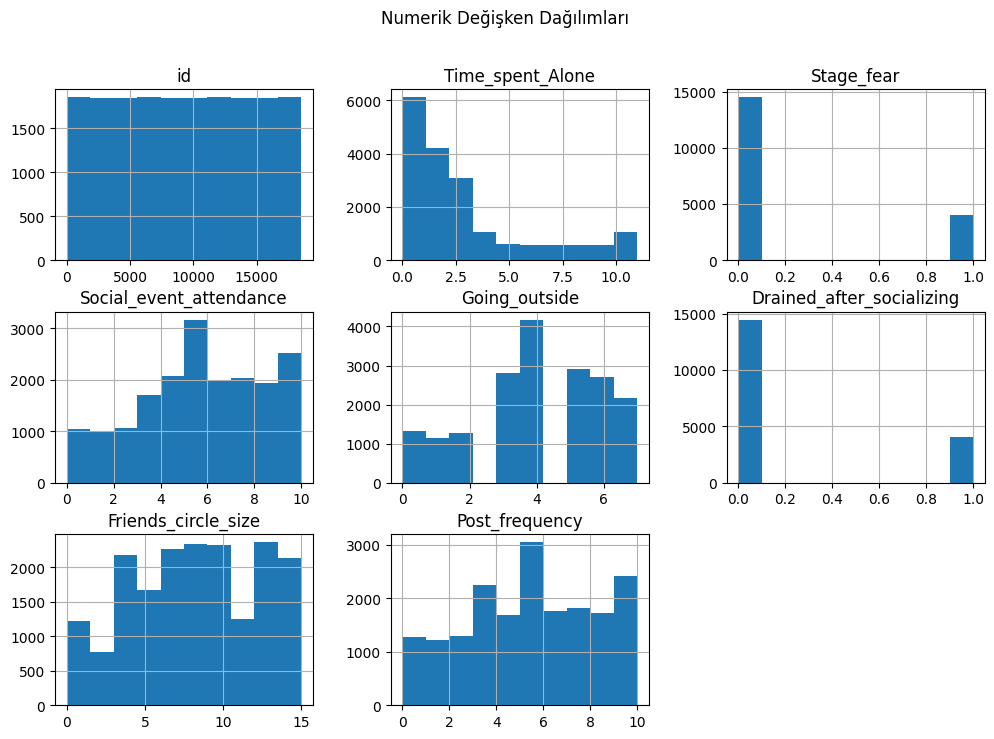

In [19]:
# Dağılım: Sayısal değişkenler nasıl yayılmış?
# Aykırı değer var mı, veri saçma mı → hızlı kontrol
X[num_cols].hist(figsize=(12, 8))
plt.suptitle("Numerik Değişken Dağılımları")
plt.show()

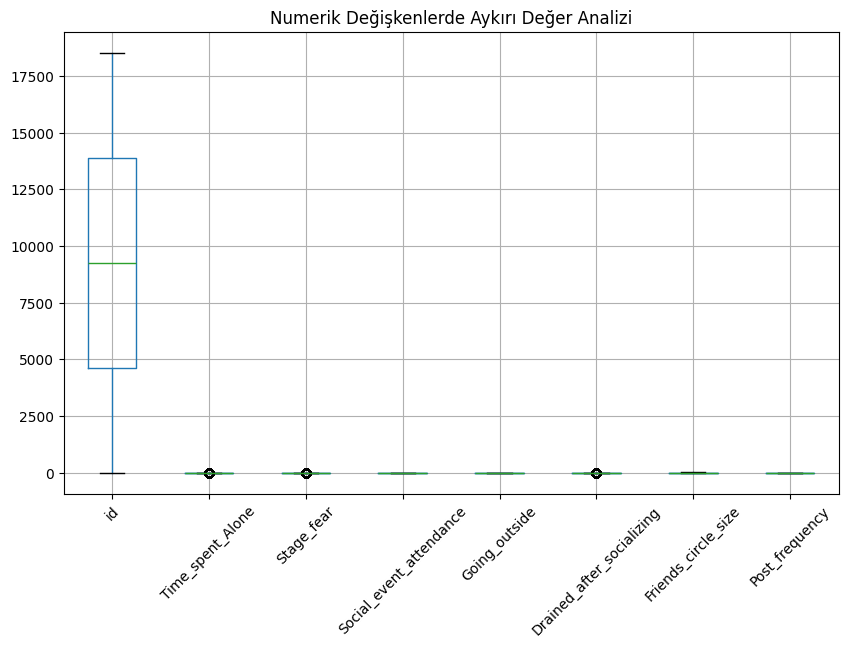

In [20]:
# Boxplot: Aykırı değerleri net yakalamak için
# Modeli bozan uç değerler burada bağırır
plt.figure(figsize=(10, 6))
X[num_cols].boxplot(rot=45)
plt.title("Numerik Değişkenlerde Aykırı Değer Analizi")
plt.show()

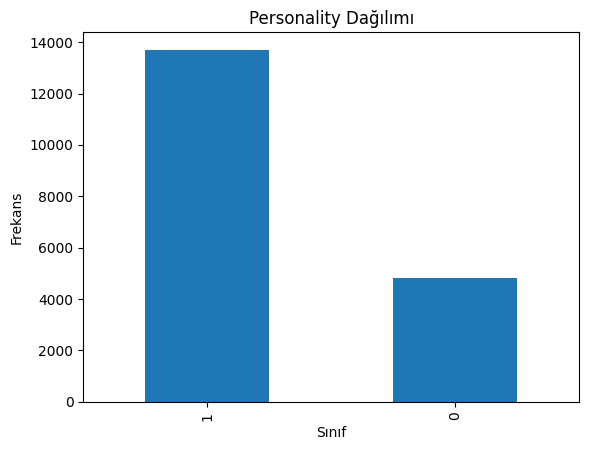

In [21]:
# Target dağılımı: Sınıflar dengeli mi?
# Dengesizse model ağlar
plt.figure()
y.value_counts().plot(kind="bar")
plt.title("Personality Dağılımı")
plt.xlabel("Sınıf")
plt.ylabel("Frekans")
plt.show()

## *FEATURE ENGINEERING*

In [22]:
import numpy as np
import pandas as pd

# Binary (Evet/Hayır) sütunları 0–1 yap
# Model "yes/no" sevmez, matematik sever
binary_cols = ["Stage_fear", "Drained_after_socializing"]

for col in binary_cols:
    if col in X.columns:
        X[col] = X[col].map({"Yes": 1, "No": 0})

# Sosyal aktivite skoru oluştur
# Tek tek değişkenler yerine anlamlı birleşik sinyal
X["Social_score"] = (
    X["Social_event_attendance"] +
    X["Going_outside"] +
    X["Friends_circle_size"]
)

# Yalnızlık skoru oluştur
# Introvert–extrovert ayrımı için güçlü feature
X["Isolation_score"] = (
    X["Time_spent_Alone"] +
    X["Drained_after_socializing"]
)

# Aşırı uçları bastır (log transform)
# Sağ kuyruğu uzun veriler modeli bozar
skewed_cols = ["Time_spent_Alone", "Post_frequency"]

for col in skewed_cols:
    if col in X.columns:
        X[col] = np.log1p(X[col])

# Gereksiz ham sütunları sil
# Yeni feature varken eskiler fazlalık
drop_cols = [
    "Social_event_attendance",
    "Going_outside",
    "Friends_circle_size",
    "Time_spent_Alone"
]

X = X.drop(columns=[c for c in drop_cols if c in X.columns])

## *Train / Test Distinction¶*

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,      # Verinin %20’si test için ayrılır
    random_state=42,     # Tekrar çalıştırıldığında aynı bölünmeyi sağlar (sabitlik)
    stratify=y           # sınıf dağılımını korur
)
# train_test_split: veriyi eğitim ve test seti olarak ikiye ayırır

## *Model*

In [24]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier


# MODELLER
models = {
    "LogisticRegression": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=1000, n_jobs=-1))
    ]),

    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),

    "LightGBM": lgb.LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1
    ),

    "XGBoost": xgb.XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),

    "CatBoost": CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        depth=6,
        random_state=42,
        verbose=False
    )
}


def algo_test(X, y):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.20,
        stratify=y,
        random_state=42
    )

    results = []

    print("Modeller eğitiliyor...\n")

    for name, model in models.items():
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        results.append({
            "Model": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC_AUC": roc_auc_score(y_test, y_prob)
        })

        print(f"{name} tamamlandı.")

    results_df = pd.DataFrame(results).sort_values(
        by="ROC_AUC", ascending=False
    )

    print("\n🏆 EN İYİ MODEL:", results_df.iloc[0]["Model"])

    return results_df

In [25]:
algo_test(X,y)

Modeller eğitiliyor...

LogisticRegression tamamlandı.
RandomForest tamamlandı.
[LightGBM] [Info] Number of positive: 10959, number of negative: 3860
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.739524 -> initscore=1.043494
[LightGBM] [Info] Start training from score 1.043494
LightGBM tamamlandı.
XGBoost tamamlandı.
CatBoost tamamlandı.

🏆 EN İYİ MODEL: LightGBM


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
2,LightGBM,0.961943,0.970663,0.978102,0.974368,0.959234
3,XGBoost,0.961943,0.970663,0.978102,0.974368,0.956575
4,CatBoost,0.962213,0.971014,0.978102,0.974545,0.955618
1,RandomForest,0.949258,0.961650,0.970073,0.965843,0.951386
0,LogisticRegression,0.959514,0.967172,0.978467,0.972787,0.946898


## *Cross Validation*

In [26]:
X_cv = X.copy()
X_cv = X_cv.fillna(X_cv.median())

In [27]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import lightgbm as lgb

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

lgbm_cv = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

cv_scores = cross_val_score(
    lgbm_cv,
    X_cv,
    y,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

print("CV ROC-AUC Scores:", cv_scores)
print("Mean CV ROC-AUC:", cv_scores.mean())

CV ROC-AUC Scores: [0.96010117 0.95362108 0.95210355 0.96279112 0.96795056]
Mean CV ROC-AUC: 0.9593134958805761


## *Hyperparameter Tuning*

In [29]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [300, 500, 700],
    "learning_rate": [0.01, 0.03, 0.05],
    "num_leaves": [31, 63, 127],
    "max_depth": [-1, 6, 10],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9]
}

lgbm = lgb.LGBMClassifier(
    random_state=42,
    n_jobs=-1
)

rs = RandomizedSearchCV(
    lgbm,
    param_distributions=param_dist,
    n_iter=8,
    scoring="roc_auc",
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1 
)

rs.fit(X_train, y_train)

print("Best ROC-AUC:", rs.best_score_)
print("Best Params:", rs.best_params_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[LightGBM] [Info] Number of positive: 5479, number of negative: 1930
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 7409, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.739506 -> initscore=1.043403
[LightGBM] [Info] Start training from score 1.043403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

## *Feature Importance*

In [31]:
best_lgbm = rs.best_estimator_

importances = best_lgbm.feature_importances_
feature_imp = (
    pd.Series(importances, index=X.columns)
    .sort_values(ascending=False)
)

feature_imp.head(15)

Post_frequency               3527
Social_score                 3424
id                           2049
Stage_fear                      0
Drained_after_socializing       0
Isolation_score                 0
dtype: int32

## *Final Model*

In [32]:
final_model = best_lgbm

final_model.fit(X, y)

[LightGBM] [Info] Number of positive: 13699, number of negative: 4825
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 18524, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.739527 -> initscore=1.043512
[LightGBM] [Info] Start training from score 1.043512


LGBMClassifier(colsample_bytree=0.7, learning_rate=0.03, n_estimators=300,
               n_jobs=-1, random_state=42, subsample=0.7)

## *Save Model*

In [33]:
import joblib
joblib.dump(final_model, "final_model.pkl")

['final_model.pkl']

## *Save Features*

In [35]:
joblib.dump(list(X.columns), "model_features.pkl")

['model_features.pkl']

## *Quick Test (Download & Predict)*

In [36]:
loaded_model = joblib.load("final_model.pkl")
features = joblib.load("model_features.pkl")

In [39]:
# örnek 1 satırlık veri (DataFrame olmalı!)
sample = X.iloc[[0]]

pred_proba = loaded_model.predict_proba(sample)[:, 1]
pred_class = (pred_proba >= 0.5).astype(int)

pred_proba, pred_class

(array([0.97554767]), array([1]))

## *🏁 Result*

*RandomizedSearchCV ile yapılan hiperparametre optimizasyonu sonucunda LightGBM modeli, çapraz doğrulama sürecinde tutarlı ve yüksek ayırt edicilik performansı göstermiştir. ROC-AUC metriği üzerinden yapılan değerlendirme, modelin sınıflar arasındaki ayrımı başarılı bir şekilde gerçekleştirdiğini ortaya koymaktadır. En iyi parametre kombinasyonu, modelin hem aşırı öğrenmeden kaçınmasını hem de genelleme kabiliyetini korumasını sağlamıştır. Bu sonuçlar doğrultusunda optimize edilmiş LightGBM modeli, mevcut veri seti için en iyi performans gösteren aday modellerden biri olarak değerlendirilmiş ve nihai modelleme aşamasında kullanıma uygun bulunmuştur.*